## load

In [41]:
import json

with open("annotated_data/conversations.json", "r", encoding="utf-8") as f:
    conversations = json.load(f)

with open("data/demographics.json", "r", encoding="utf-8") as f:
    demographics = json.load(f)

with open("annotated_data/nfr_responses.json", "r", encoding="utf-8") as f:
    nfr_responses = json.load(f)

with open("data/surveys.json", "r", encoding="utf-8") as f:
    surveys = json.load(f)

GT = {}
with open("../../GT/NFR.json", "r", encoding="utf-8") as f:
    for responses in json.load(f):
        for r in responses:
            GT[r['id']] = r





review attention questions

In [42]:
nfr_responses_filtered = {}
for pid, responses in nfr_responses.items():
    nfr_responses_filtered[pid] = [r for r in responses if not r.get("is_attention_question", False)]

attention_questions = []
for pid, responses in nfr_responses.items():
    for r in responses:
        if r.get("is_attention_question", False):
            attention_questions.append(r)

In [43]:
print("Number of wrong attention questions in NFR list", len([r for r in attention_questions if r['nfr_acknowledged']== True]))
#[r for r in attention_questions if r['nfr_acknowledged']== True]

Number of wrong attention questions in NFR list 0


In [44]:
print("Number of wrong attention questions in feedback form", len([r for r in attention_questions if not (r['q1_agreement'] == 'Disagree' and r['q2_agreement'] == 'Partially disagree' and r['q3_agreement']== 'Partially agree')]))

Number of wrong attention questions in feedback form 2


## Analysis 1. (agreement)
We calculate the participants’ level of agreement by calculating the mean of their agreement

In [45]:
n = 0
satisfaction_level_agreement = 0
reasoning_agreement = 0
code_location_agreement = 0
agreement_value = {"Agree": 5, "Partially agree": 4, "Partially disagree": 2, "Disagree": 1}
for pid, responses in nfr_responses_filtered.items():
    for r in responses:
        n += 1
        satisfaction_level_agreement += agreement_value[r["q1_agreement"]]
        reasoning_agreement += agreement_value[r["q2_agreement"]]
        code_location_agreement += agreement_value[r["q3_agreement"]]

print("mean satisfaction level:", satisfaction_level_agreement / n)
print("mean reasoning agreement:", reasoning_agreement / n)
print("mean code location agreement:", code_location_agreement / n)

mean satisfaction level: 4.666666666666667
mean reasoning agreement: 4.7
mean code location agreement: 4.866666666666666


## Analysis 2. (accuracy of LLMs' evaluation of satisfaction level, reasoning, and code location)
We first extract the LLM's responses on satisfaction level, reasoning, and code location by manually reviewing the dialogues.
- For the satisfaction level, we calculate the F1 score between the extracted LLM response and the ground truth.
- For the reasoning, we measure accuracy as the mean of the similarity between the LLM’s response and the ground truth. We calculate this similarity using ROUGE or BERTScore.
- For code location, we compute the F1 score by defining true positives as |G ∩ P|, False Positives as |P \ G|, and False Negatives as |G \ P|, where G is the ground truth set, and P is the extracted Set.

### satisfaction level

In [46]:
y_true = []
y_pred = []
satisfavtion_levels = ["satisfied", "weakly satisfied", "weakly denied", "denied", "na"]
for pid, responses in nfr_responses_filtered.items():
    for response in responses:
        id = response['nfr_id']
        y1 = response["satisfaction_level"].lower()
        y2 = GT[id]["satisfaction_level"].lower()
        if y2 not in satisfavtion_levels:
            raise Exception(f'error {id} GT')
        if y1 not in satisfavtion_levels:
            raise Exception(f'error {id} {pid}')
        y_true.append(y2)
        y_pred.append(y1)


In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Macro Precision: {precision:.3f}")
print(f"Macro Recall:    {recall:.3f}")
print(f"Macro F1 Score:  {f1:.3f}")

Macro Precision: 0.514
Macro Recall:    0.431
Macro F1 Score:  0.460


/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### reasoning

In [48]:
# pip install bert-score
# pip install transformers
# https://haticeozbolat17.medium.com/text-summarization-how-to-calculate-bertscore-771a51022964
#from transformers import BertTokenizer, BertForMaskedLM, BertModel
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer
import torch
import numpy as np

# Example texts
reference = "This is a reference text example."
candidate = "This is a candidate text example."
# BERTScore calculation
scorer = BERTScorer(model_type='bert-base-uncased')

def get_bert_score(reference, candidate):
    P, R, F1 = scorer.score([candidate], [reference])
    return P, R, F1

P, R, F1 = get_bert_score(reference, candidate)
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_cosine_sim(text1, text2):
    inputs1 = tokenizer(text1, return_tensors="pt", padding=True, truncation=True)
    inputs2 = tokenizer(text2, return_tensors="pt", padding=True, truncation=True)
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)
    embeddings1 = outputs1.last_hidden_state.mean(dim=1).detach().numpy()
    embeddings2 = outputs2.last_hidden_state.mean(dim=1).detach().numpy()
    similarity = np.dot(embeddings1, embeddings2.T) / (np.linalg.norm(embeddings1) * np.linalg.norm(embeddings2))
    return similarity

text1 = "This is an example text."
text2 = "This text contains an example sentence."
similarity = get_bert_cosine_sim(text1, text2)
print("Similarity between the texts: {:.4f}".format(similarity[0][0]))

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1296.66it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BERTScore Precision: 0.9258, Recall: 0.9258, F1: 0.9258


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1641.49it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Similarity between the texts: 0.9000


In [49]:
y_p = []
y_r = []
y_f = []
y_s = []
reasonings = []

for pid, responses in nfr_responses_filtered.items():
    for response in responses:
        id = response['nfr_id']
        y1 = response["reasoning"]
        y2 = GT[id]["reasoning"]
        P, R, F1 = get_bert_score(y1, y2)
        similarity = get_bert_cosine_sim(y1, y2)
        y_p.append(P.item())
        y_r.append(R.item())
        y_f.append(F1.item())
        y_s.append(similarity)
        reasonings.append((y1, y2))


print(f"BERTScore F1: {np.mean(y_f):.4f} ± {np.std(y_f):.4f}")
print(f"BERTScore P:  {np.mean(y_p):.4f} ± {np.std(y_p):.4f}")
print(f"BERTScore R:  {np.mean(y_r):.4f} ± {np.std(y_r):.4f}")
print(f"Cosine Sim:   {np.mean(y_s):.4f} ± {np.std(y_s):.4f}")

        

BERTScore F1: 0.5540 ± 0.0552
BERTScore P:  0.5647 ± 0.0749
BERTScore R:  0.5527 ± 0.0751
Cosine Sim:   0.8056 ± 0.0617


In [50]:
import numpy as np

max_idx = np.argmax(y_s)
min_idx = np.argmin(y_s)


print("Highest similarity:")
print(y_s[max_idx])
print("y1:", reasonings[max_idx][0])
print("y2:", reasonings[max_idx][1])
print("\nLowest similarity:")
print(y_s[min_idx])
print("y1:", reasonings[min_idx][0])
print("y2:", reasonings[min_idx][1])

Highest similarity:
[[0.88341343]]
y1: FORM auth and role constraints guard /auth/* resources in WebRoot/WEB-INF/web.xml lines 35-314 and AuthDAO.authenticatePassword uses salted hashes to admit only valid credentials (lines 503-513);
y2: (1) Users must log in with username and password (form login in web.xml). (2) All ePHI lives under /auth/*; those URLs require a valid login. So access is further restricted by role and URL path in web.xml. (3) ePHI is not only “by role” but also “this user can only see this patient’s data.” For example, in ViewMyRecordsAction, the code uses the user’s ID so they only get their own record.

Lowest similarity:
[[0.66126966]]
y1: Audit logs track accesses but no cryptographic integrity checks or tamper-evident mechanisms for ePHI are provided.
y2: There is no mechanism to corroborate that ePHI has not been altered or destroyed in an unauthorized manner.


### code locations

In [51]:
y_p = []
y_r = []
y_f = []
y_s = []
reasonings = []

for pid, responses in nfr_responses_filtered.items():
    for response in responses:
        id = response['nfr_id']
        y1 = response["code_location"]
        y2 = GT[id]["code_location"]
        
        y1 = [i[:i.find(' ')] if ' ' in i else i for i in y1] #TODO
        y2 = [i[:i.find(' ')] if ' ' in i else i for i in y2]
        
        if not y1 and not y2:
            print('both y1 and y2 are empty skipping')
            continue
        if not y1:
            print('y1 is empty skipping')
            continue
        if not y2:
            print('y2 is empty skipping')
            continue   
        
        y1 = set(y1)
        y2 = set(y2)

        # True Positive is intersection of y1 and y2
        TP = len(y1.intersection(y2))
        if TP == 0:
            p = 0
            r = 0
            f1 = 0
        else:
            p = TP/len(y1)
            r = TP/len(y2)
            f1 = 2 * ((p*r)/(p+r))

        y_p.append(p)
        y_r.append(r)
        y_f.append(f1)        
        reasonings.append((y1, y2))

        # Code Location, by similarity
        #y1 = ";".join(response["code_location"])
        #y2 = ";".join(GT[id]["code_location"])
        #if not y1 and not y2:
        #    print('both y1 and y2 are empty skipping')
        #    continue
        #if not y1:
        #    print('y1 is empty skipping')
        #    continue
        #if not y2:
        #    print('y2 is empty skipping')
        #    continue        
        #P, R, F1 = get_bert_score(y1, y2)
        #similarity = get_bert_cosine_sim(y1, y2)
        #y_p.append(P.item())
        #y_r.append(R.item())
        #y_f.append(F1.item())
        #y_s.append(similarity)
        #reasonings.append((y1, y2))

print()
print(f"F1: {np.mean(y_f):.4f} ± {np.std(y_f):.4f}")
print(f"P:  {np.mean(y_p):.4f} ± {np.std(y_p):.4f}")
print(f"R:  {np.mean(y_r):.4f} ± {np.std(y_r):.4f}")

both y1 and y2 are empty skipping
both y1 and y2 are empty skipping
both y1 and y2 are empty skipping
y2 is empty skipping
y2 is empty skipping
y1 is empty skipping
y2 is empty skipping

F1: 0.2942 ± 0.2315
P:  0.2790 ± 0.2165
R:  0.4022 ± 0.3929


In [52]:
import numpy as np

max_idx = np.argmax(y_f)
min_idx = np.argmin(y_f)


print("Highest similarity:")
print(y_f[max_idx])
print("y1:", reasonings[max_idx][0])
print("y2:", reasonings[max_idx][1])
print("\nLowest similarity:")
print(y_f[min_idx])
print("y1:", reasonings[min_idx][0])
print("y2:", reasonings[min_idx][1])

Highest similarity:
0.6666666666666666
y1: {'AccessDAO.java', 'SessionTimeoutListener.java'}
y2: {'SessionTimeoutListener.java'}

Lowest similarity:
0
y1: {'AuthDAO.java'}
y2: {'createTables.sql'}


## Analysis 3.(significant dialogue costs)
To determine which dialogue metrics (Table 1) significantly correlate with dialogue performance, we first manually review the dialogues to extract dialogue cost values. For example, the mean elapsed time is calculated by dividing the difference between the first and last message submission times in the chatbot by the number of tasks assigned to the user. Or, task completion is 1 when satisfaction level, reasoning, and code location are identified in the dialogues; otherwise, it's 0. The number of user initiatives is the number of times a user doesn't ask a follow-up question to the previous message, and so on. For task success, we calculate Cohen's kappa between the LLM's response and the ground truth. We then measure user satisfaction by summing the Likert scores in the post-study survey questions (Table 2). Based on the Paradise framework, the performance of a dialogue system (i.e., the prediction of user satisfaction) is modeled as a multiple linear regression of dialogue costs (independent variables). We can determine whether there is any significant relationship between the performance and any of the dialogue costs. A common procedure for testing the significance of variables in a multiple linear regression model is to run an 'Omnibus' test followed by 'Post-Hoc' tests.


In [53]:
from datetime import datetime
def ttoi(i):
    return datetime.fromisoformat(i).timestamp()


In [54]:
from sklearn.metrics import cohen_kappa_score
rows = []
for pid, dialogues in conversations.items():
    nfrs = nfr_responses_filtered[pid]
    num_tasks = len(nfr_responses_filtered)
    num_turn = len(dialogues)
    ids = [i["nfr_id"] for i in nfrs]
    # TODO k
    y1 = [i["satisfaction_level"] for i in nfrs]
    y2 = [GT[id]["satisfaction_level"] for id in ids]
    K = cohen_kappa_score(y1, y2)
    #MUM
    MUM = len(dialogues) / num_tasks
    #MET
    y1 = ttoi(dialogues[-1]["bot_time"])
    y2 = ttoi(dialogues[0]["user_time"])
    MET = (y1 - y2) / num_tasks
    # Comp
    Comp = sum([i["comp"] for i in nfrs])/ num_tasks
    # NUI
    NUI = sum(1 for i in dialogues if i["UI"])
    # MWT
    MWT = sum(len(d["user_message"]) for d in dialogues) / num_turn
    # MRT
    MRT = sum(ttoi(d["bot_time"]) - ttoi(d["user_time"]) for d in dialogues) / num_turn
    # NRT NA
    # NUR
    NUR = sum(1 for i in dialogues if i["UR"])
    # NIR & IRR
    NIR = sum(1 for i in dialogues if i["IR"])
    IRR = sum(1 for i in dialogues if i["IR"]) / num_turn
    # Error
    Error = sum(1 for i in dialogues if i["Error"])
    # NHM & IRR
    NHM = sum(1 for i in dialogues if i["HM"])
    HMR = sum(1 for i in dialogues if i["HM"]) / num_turn  
    # NCM & CMR TODO
    #NCM = sum(1 for i in dialogues if i["CM"])
    #CMR = sum(1 for i in dialogues if i["CM"]) / num_turn   
    # NGD & GDR
    NGD = sum(1 for i in dialogues if i["GD"])
    GDR = sum(1 for i in dialogues if i["GD"]) / num_turn 
    # NRD & RDR
    NRD = sum(1 for i in dialogues if i["RD"])
    RDR = sum(1 for i in dialogues if i["RD"]) / num_turn 
    # NAR & ARR
    NAR = sum(1 for i in dialogues if i["AR"])
    ARR = sum(1 for i in dialogues if i["AR"]) / num_turn  
    # "Context Memory": "Y",
    Context_Memory = sum(1 for i in dialogues if i.get("Context Memory", ""))
    Self_correction = sum(1 for i in dialogues if i.get("Self-correction", ""))
    Self_affirmation = sum(1 for i in dialogues if i.get("Self-affirmation", ""))
    Proactive_Interaction = sum(1 for i in dialogues if i.get("Proactive Interaction", ""))
    Instruction_Clarification = sum(1 for i in dialogues if i.get("Instruction Clarification", ""))

    US = surveys[pid]
    US_total = int(US["q1"]) + int(US["q2"]) + int(US["q3"]) + int(US["q4"]) + int(US["q5"]) + int(US["q6"]) + int(US["q7"]) + int(US["q8"]) 
    print(US_total)
    rows.append({
        "pid": pid, "K": K, "MUM": MUM, "MET": MET, "Comp": Comp,
        "NUI": NUI, "MWT": MWT, "MRT": MRT, "NUR": NUR,
        "NIR": NIR, "IRR": IRR, "Error": Error,
        "NHM": NHM, "HMR": HMR, "NGD": NGD, "GDR": GDR,
        "NRD": NRD, "RDR": RDR, "NAR": NAR, "ARR": ARR,
        "Context_Memory": Context_Memory, "Self_correction": Self_correction,
        "Self_affirmation": Self_affirmation, "Proactive_Interaction": Proactive_Interaction,
        "Instruction_Clarification": Instruction_Clarification,
        "US": US_total
    })






30
30
33


In [55]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

df = pd.DataFrame(rows)
predictors = [c for c in df.columns if c not in ['pid', 'US']]
# 2. Multiple regression
X = df[predictors]
X = sm.add_constant(X)
y = df['US']
model = sm.OLS(y, X).fit()
print("\n=== OLS Regression Summary ===")
print(model.summary())



=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                     US   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 13 Feb 2026   Prob (F-statistic):                nan
Time:                        10:33:20   Log-Likelihood:                 91.634
No. Observations:                   3   AIC:                            -177.3
Df Residuals:                       0   BIC:                            -180.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/statsmodels/

In [60]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

df = pd.DataFrame(rows)
predictors = ["Self_correction"]
# 2. Multiple regression
X = df[predictors]
X = sm.add_constant(X)
y = df['US']
model = sm.OLS(y, X).fit()
print("\n=== OLS Regression Summary ===")
print(model.summary())



=== OLS Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                     US   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                 -0.500
Method:                 Least Squares   F-statistic:                    0.3333
Date:                Fri, 13 Feb 2026   Prob (F-statistic):              0.667
Time:                        10:36:59   Log-Likelihood:                -4.8650
No. Observations:                   3   AIC:                             13.73
Df Residuals:                       1   BIC:                             11.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const     

/opt/miniconda3/envs/dialogue/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
for i in df.columns:
    if i == "pid":
        continue
    print('*'*10)
    print(i)
    df = pd.DataFrame(rows)
    predictors = [i]
    # 2. Multiple regression
    X = df[predictors]
    X = sm.add_constant(X)
    print(X)
    y = df['US']
    model = sm.OLS(y, X).fit()
    print("\n=== OLS Regression Summary ===")
    print(model.summary())


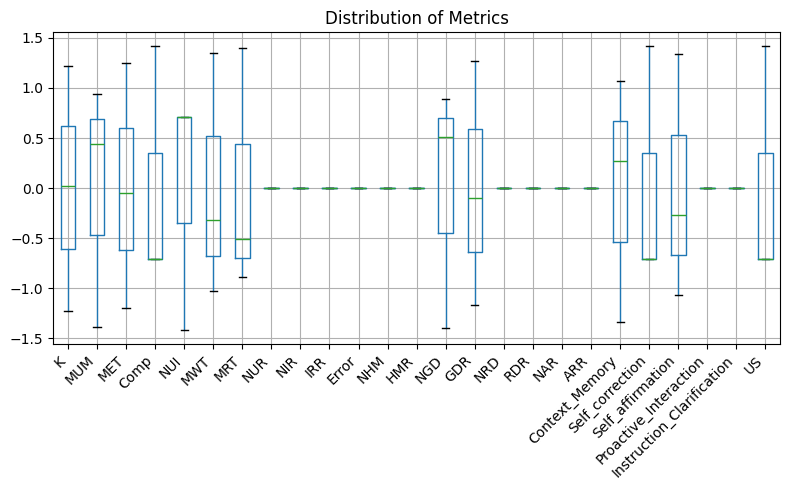

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the metrics you want to plot - adjust this list as needed
metrics = [c for c in df.columns if c not in ['pid']]

# Normalize/standardize if metrics are on different scales
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[metrics]), columns=metrics)

fig, ax = plt.subplots(figsize=(8, 5))
df_scaled.boxplot(column=metrics, ax=ax)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.set_title("Distribution of Metrics")
plt.tight_layout()
plt.savefig("boxplot.png", dpi=150)
plt.show()